In [1]:
# Tabs I have open
# https://xgboost.readthedocs.io/en/stable/python/examples/multioutput_regression.html#sphx-glr-python-examples-multioutput-regression-py
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor
# https://xgboost.readthedocs.io/en/stable/parameter.html
# https://xgboost.readthedocs.io/en/stable/prediction.html
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py
# https://machinelearningmastery.com/xgboost-for-regression/
# https://machinelearningmastery.com/regression-metrics-for-machine-learning/

In [185]:
#!pip install xgboost
#!pip install hyperopt
#!pip install kaleido

In [3]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import accuracy_score, SCORERS
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, Trials, hp, tpe, STATUS_OK

In [98]:
import numpy as np
from scipy.stats import kstest, anderson

from math import ceil
import itertools

from PIL import Image
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import graphviz
import ssl
from glob import glob

#from annoy import AnnoyIndex
import random
import pandas as pd
from scipy import spatial

import os
from os.path import join as pj
from shutil import copy2

In [5]:
!jupyter nbconvert --to script testing_xgboost.ipynb

[NbConvertApp] Converting notebook testing_xgboost.ipynb to script
[NbConvertApp] Writing 40085 bytes to testing_xgboost.py


In [6]:
cwd = os.getcwd()
home_dir = os.environ['HOME']

In [7]:
png_tiled_dir  = pj(cwd, "labeled_png_out")
good_labeled_dir  = pj(png_tiled_dir, "good")

inputs_dir = pj(cwd, "galfit_inputs")
good_inputs_dir = pj(inputs_dir, "good")
not_good_inputs_dir = pj(inputs_dir, "not_good")

outputs_dir = pj(cwd, "galfit_outputs")
good_outputs_dir = pj(outputs_dir, "good")
not_good_outputs_dir = pj(outputs_dir, "not_good")

sparc_out_dir = pj(home_dir, "run2_1000_galfit", "sparcfire-out")

# resize_obs_dir = os.path.join(png_resize_dir, "obs")
# resize_models_dir = os.path.join(png_resize_dir, "models")
# resize_residuals_dir = os.path.join(png_resize_dir, "residuals")

# features_files_dir = os.path.join(cwd, "image_feature_vectors")

# features_obs_dir = os.path.join(features_files_dir, "obs")
# features_models_dir = os.path.join(features_files_dir, "models")

In [8]:
# Used to get organized
def generate_labels_from_imgs(all_inputs_path, good_folder_path):
    
    # good galaxies are named ###_combined.png
    # inputs are named ###.in
    
    good_galaxy_names = list(map(lambda i: i.split("_")[0], os.listdir(good_folder_path)))
    all_galaxy_names = list(map(lambda i: i.replace(".in", ""), os.listdir(all_inputs_path)))
    
    label_dict = {i:(1 if i in good_galaxy_names else 0) for i in all_galaxy_names}
    
    return label_dict

In [9]:
def organize_template_files(in_dict, sparcfire_out_dir, labels_top_dir = os.getcwd(), good_name = "good", not_good_name = "not_good"):
    for gname, label in label_dict.items():
        if label:
            label_name = good_name
        else:
            label_name = not_good_name
        
        # There will always be a generated feedme
        # There should always be a generated output (because labeled) but just in case...
        # Copy that first so the except catches before trying to copy the input that way we don't have a mismatch
        try:
            copy2(pj(sparcfire_out_dir, gname, "galfit.01"), pj(labels_top_dir, "galfit_outputs", label_name, gname + ".out"))
            copy2(pj(sparcfire_out_dir, gname, "autogen_feedme_galfit.in"), pj(labels_top_dir, "galfit_inputs", label_name, gname + ".in"))
        except FileNotFoundError:
            print(f"No output found for {gname}, continuing to copy...")
    return

In [10]:
#label_dict = generate_labels_from_imgs(inputs_dir, good_labeled_dir)

In [11]:
#organize_template_files(label_dict, pj(home_dir, "run2_1000_galfit", "sparcfire-out"))

In [12]:
# Used if already organized
def generate_labels_from_paths(top_dir = os.getcwd(), good_dir = "good", not_good_dir = "not_good"):
    
    # good galaxies are named ###_combined.png
    # inputs are named ###.in
    
    good_fits = list(map(lambda i: i.split(".")[0], os.listdir(pj(top_dir, good_dir))))
    not_good_fits = list(map(lambda i: i.split(".")[0], os.listdir(pj(top_dir, not_good_dir))))
    all_fits = good_fits + not_good_fits
    
    # 1 good, 0 bad
    label_dict = {i:(1 if i in good_fits else 0) for i in all_fits}
    label_dict.pop("")
    
    return label_dict

In [161]:
# Borrowed and modified from in_out_comparison
def galfit_param_grab(filename):
    
    # This function handles grabbing and storing the values from galfit files (input and output???)
    # It's written to generally handle both and stores everything in a dict of dicts
    # See parameter_names list for the corresponding labels
    # {Component: {Parameter : Value}}
    
    try: 
        # Grabbing the filename
        #input_filename = glob_name(galaxy_path, '', filename) 
        input_file = open(filename,'r')
    
    except:
        print("Can't open to read the " + filename + ". Continuing...")
    
    else:
        input_in = input_file.readlines()
        input_file.close()
        
        # Initialzing parameters.
        input_dict = {}
        #param_dict = {}
        param_list = []
        parameter_names = []
        component_number = "0"
        fourier_num = 1
        #component_name = "bad programmer bad!"
        
        # For convenient checking down the line.
        n_range = [str(x) for x in range(3,11)] + \
                  ['R' + str(x) for x in range(1,11)] + \
                  ['F' + str(x) for x in range(1,6)]

        # Looping through the galfit file.
        for line in input_in[1:]:
            line = line.replace("\n","")
            
            # Grabbing crop coordinates for sanity checking
            if line.startswith("H)"):
                values = line.split()
                input_dict["Crop Rad"] = [0.5*(float(values[2]) - float(values[1]))]
                parameter_names.append("Crop Rad")
            
            # For those pesky blanks
            if not line:
                # I don't use continue here I think because the blank lines indicate the end
                # of a component
                line = 'hi hi'
                
            # Split for convenience and removing the ) for consistency among parameter numbers
            values = line.split()
            values[0] = values[0].replace(")", "")
                
            # Grabbing the component number and innitializing the parameter dictionary.
            # Essentially by doing it here, we guarantee that as we go through the lines
            # we initialize a new param_dict to hold that component's parameters.
            # This only triggers at every new component so there's no chance of triggering
            # while grabbing the rest. 
            if "Component" in line and "number:" in line:
                component_number = line[-1]
                #param_dict = {}
                param_list = []
                param_suffix = ""
                
                # To avoid repeating parameter names per sklearn/xgboost
                if component_number == "1":
                    param_suffix = " bulge"
                    
                elif component_number == "2":
                    param_suffix = " disk"
                    
                # For sky component
                elif component_number == "3": 
                    n_range += ["1", "2"]
             
            # Overwrites sersic unfortunately...
            #elif values[0] == "0":
                #component_name = values[1]

            # Storing the parameters themselves
            elif values[0] in n_range:
                
                param_name = line.split("#")[-1].strip() + param_suffix
                param_name = param_name.replace("[", "(")
                param_name = param_name.replace("]", ")")

                # Accounting for the Fourier modes
                # Also we have to put everything in a list to appease pandas
                if line[0] == 'F':
                    parameter_names.append(f"Fourier Amplitude {fourier_num}")
                    parameter_names.append(f"Fourier Phase Angle {fourier_num}")
                    fourier_num += 1
                    #param_dict["Fourier Amplitude"] = [values[1]]
                    #param_dict["Fourier Phase Angle"] = [values[2]]
                    param_list.append(values[1])
                    param_list.append(values[2])

                else:
                    parameter_names.append(param_name)
                    #param_dict[param_name] = [values[1]]
                    
                    # Convert to positive radians for testing loss function
                    if "degree" in param_name.lower() or "angle" in param_name.lower():
                        # Negative -> positive
                        if float(values[1]) < 0: 
                            values[1] = float(values[1]) + 180
                            
                        # Convert to radians
                        values[1] = str(float(values[1]) * np.pi/180)
                        
                    param_list.append(values[1])

            # There's a blank line between parameters so this is where we finalize the 
            # parameter dictionary and place it in the main dict.
            # Resetting component_number just in case and to store any extra faff which will then be popped.
            else:
                #input_dict[component_number] = param_dict
                input_dict[component_number] = param_list
                component_number = "0"

        # Popping extra faff
        input_dict.pop("0")
        #input_dict.pop("bad programmer bad!")
        #input_dict.pop('3')
        #print(input_dict)
        return input_dict, parameter_names

    return None, None

In [14]:
def flatten_to_pandas(in_dict, parameter_names, gname):
    
    param_values = np.array([value for sublist in in_dict.values() for value in sublist])
    param_values = param_values.reshape(1, len(param_values))
        
    all_data = pd.DataFrame(param_values, index = [gname], columns = parameter_names, dtype = np.float32)
    all_data = all_data.drop(columns=['----- bulge'])
    all_data = all_data.drop(columns=['----- disk'])
    
#     for component, sub_list in in_dict.items():
#         print(component)
#         print(sub_dict)
#         component_df = pd.DataFrame.from_dict(sub_dict, dtype = float)
        
#         if not all_data.empty:
#             #all_data.merge(component_df, how = "outer")
#         else:
#             all_data = component_df
        
    return all_data

In [15]:
def build_df(label_dict: dict, label_dirs, file_suffix: str):
    
    out_df = pd.DataFrame()

    for gname, label in label_dict.items():

        # 0 bad, 1 good
        if label == 0:
            input_dir = label_dirs[0]
            #str_label = "not_good"
        else:
            input_dir = label_dirs[1]
            #str_label = "good"

        gal_dict, param_names = galfit_param_grab(pj(input_dir, gname + file_suffix))
        if not param_names: continue
        
        for i, param in enumerate(param_names):
            if param in param_names[:i]:
                param += ""

        gname_df = flatten_to_pandas(gal_dict, param_names, gname)
        gname_df["label"] = label #str_label
        out_df = pd.concat([out_df, gname_df])

    # For the input galaxies, we have a lot of held values, these are uneccessary
    # https://stackoverflow.com/a/39658662
    nunique = out_df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    out_df.drop(columns = cols_to_drop, inplace = True)
    
    return out_df

In [16]:
def choose_df(top_dir, label_dirs, file_suffix):
    # top_dir = inputs_dir
    # label_dirs = [not_good_inputs_dir, good_inputs_dir] 
    # file_suffix = ".in", ".out"
    label_dict = generate_labels_from_paths(top_dir = top_dir)
    out_df = build_df(label_dict, label_dirs = label_dirs, file_suffix = file_suffix)
    return out_df

In [17]:
# Per https://xgboost.readthedocs.io/en/stable/python/python_intro.html
# For training *regressor* on good data
def split_save_df_reg(*args, file_prefixes = [], col_ignore = {}, gal_filter = {}, sklearn = False):
    # col_ignore must be list of list of columns since we drop different things for different df
    # gal_filter must be given as: `column name` cond value, i.e. "`Asymptotic spiral powerlaw disk` <= 1"
    # Note, the conditions are what we *don't want*
    
    assert len(file_prefixes) == len(args), "File prefixes must be same length as # of dataframes being passed in! Try again"
    #assert col_ignore == len(args), "col_ignore must be same length as # of dataframes being passed in! Try again"
    
    return_dict = {}
    
    # Specifically looking for good galaxies since we're not classifying
    #gal_filter.append("label != 1") 
    #gal_filter = " or ".join(gal_filter)
    
    galaxies_to_drop = [in_df.query(
                                    " or ".join(gf + ["label != 1"])
                                    ).index 
                        for in_df, gf in zip(args, gal_filter.values()) if gf]
    
    # Unpacking to keep the list comp ;)
    galaxies_to_drop = list(itertools.chain.from_iterable(galaxies_to_drop))
    print(f"Keeping {len(args[0]) - len(galaxies_to_drop)} galaxies (out of {len(args[0].query('label == 1'))})")
    
    # Generator go fast brrrrr
    # _ = (
    # df.drop(index = galaxies_to_drop, inplace = True) for df in args
    # )
    
    for in_df, file_prefix in zip(args, file_prefixes):
        # Filter and exclude
        
        exclude = ['label'] + col_ignore.get(file_prefix, [])
        
        in_df_good = in_df.drop(index = galaxies_to_drop, columns = exclude)
        
        label = pd.DataFrame(np.ones(len(in_df_good)), columns = ["label"], dtype = "int")
            
        # Pass random_state = 0 to guarantee input and output are lined up
        X_train, X_test, y_train, y_test = train_test_split(in_df_good, label, test_size=.3, random_state = 0)
    
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest  = xgb.DMatrix(X_test,  label = y_test)
        ddata  = xgb.DMatrix(in_df_good, label = label)

        print(f"Saving dmatrices to file: {file_prefix}.train/test/data")
        dtrain.save_binary(f'{file_prefix}.train')
        dtest.save_binary(f'{file_prefix}.test')
        ddata.save_binary(f'{file_prefix}.data')
        
        in_df_good["label"] = list(label.label)
        if sklearn:
            return_dict[file_prefix] = X_train, X_test, y_train, y_test, in_df_good
        else:
            return_dict[file_prefix] = dtrain, dtest, ddata, in_df_good, label

    return return_dict

In [18]:
def load_data(file_prefix):
    dtrain = xgb.DMatrix(f'{file_prefix}.train')
    dtest  = xgb.DMatrix(f'{file_prefix}.test')
    ddata  = xgb.DMatrix(f'{file_prefix}.data')
    
    return dtrain, dtest, ddata

In [182]:
def make_hist_plots(test_data, predicted_data, grid = False, bins = 30, adjust = 2.17, save = False):
    # Assume both test_data, predicted_data are pandas df
    # Number of bins arrived at empirically

    rows = len(test_data.columns)
    cols = 1
    
    if grid:
        rows = ceil(rows / 2)
        # Restricting to 2 for now since histograms are wide
        cols = 2
        
    fig = make_subplots(rows = rows, cols = cols, start_cell="top-left") 

    for i, col_name in enumerate(predicted_data.columns): 

        # plotly indexes at 1 
        if grid:
            row = ceil((i + 1)/rows) 
            col = i % cols + 1 
        else:
            row = i + 1
            col = 1    

        #print(row, col) 

        fig.add_trace(go.Histogram(x = test_data[col_name],
                                   nbinsx = bins,
                                   name = "Data",
                                   legendgroup = col_name,
                                   legendgrouptitle_text = col_name,
                                   marker_color = '#FFA15A'), #col_name + " test"), 
                      row = row, col = col) 
        
        fig.add_trace(go.Histogram(x = predicted_data[col_name],
                                   nbinsx = bins,
                                   name = "Predicted",
                                   legendgroup = col_name,
                                   legendgrouptitle_text = col_name,
                                   marker_color = 'cornflowerblue'), #col_name + " pred"), 
                      row = row, col = col)

        fig.update_layout(barmode='overlay')#,
                          #xaxis_title_text = col_name)

    fig.update_traces(opacity = 0.6)
    height = rows*200
    width = 800
    # For legend placement
    # higher, less distance, lower, more distance
    adjust = adjust
    fig.update_layout(height = height, width = width,
                      legend_tracegroupgap = height / (adjust*len(in_test.columns)))

    fig.show()
    
    if save:
        filename = col_name.replace(" ", "_")
        fig.write_image(f"hist_plots/{filename}.svg")

In [162]:
galfit_in_df = choose_df(inputs_dir, [not_good_inputs_dir, good_inputs_dir], ".in")
galfit_out_df = choose_df(outputs_dir, [not_good_outputs_dir, good_outputs_dir], ".out")

In [21]:
# TODO: INSERT FILTER STEP HERE
# If only for evaluation (i.e. weird bulge values)

In [22]:
#TODO: FILTER OUT PREVIOUS GALFIT RESULTS FOR NON-PHYSICAL DATA, I.E. SERSIC INDEX TOO HIGH OR TOO LOW IN GOOD DATA
# Convert angles to radians -- done
# weight spiral law(?), look up how weighting works -- doesn't work
# Make better plots (seaborn?)
# Use physics based constraints to filter results
# Determine better loss method? Hmmmmm https://stats.stackexchange.com/a/445454
# For +/- things (like angle) find some way to use absolute value while retaining distribution, see if that makes things better

In [160]:
# in_train/test should always have fewer exclusions and those exclusions must also be in the out_train/test
# so that the algo isn't predicting things sight unseen
sklearn = True

file_prefixes = ["reduced_galfit_in", "reduced_galfit_out"]
ignore_galfit_in  = ["Bar radius (pixels) disk", "Fourier Amplitude 2"]
ignore_galfit_out = ["Crop Rad",
                     "R_e (effective radius)   (pix) bulge", # Bulge radius goes crazzyyyyyy
                     "Inclination to L.o.S. (degrees) disk", # Trust sparc/galfit on this one
                     "Spiral inner radius (pixels) disk",
                     "Spiral outer radius (pixels) disk",
                     "Fourier Amplitude 1",
                     "Fourier Amplitude 2",
                     "Fourier Phase Angle 1",
                     "Fourier Phase Angle 2",
                     "Sky background at center of fitting region (ADUs)", # Trust galfit on this one
                     "dsky/dx (sky gradient in x)     (ADUs/pix)", # if we include them, does it get better? for future testing
                     "dsky/dy (sky gradient in y)     (ADUs/pix)"
                    ]

ignore_galfit = (ignore_galfit_in, ignore_galfit_out)
col_ignore = {fp:ig for fp, ig in zip(file_prefixes, ignore_galfit)}

# Not all df may have these columns
# For instance, I hold the input constant for some variables (sersic index) so the input
# df won't have those columns.
in_filter = []
out_filter = [#"`Asymptotic spiral powerlaw disk` <= 1",
              "`Sersic index n (de Vaucouleurs n=4) bulge` > 14",
              "`Sersic index n (de Vaucouleurs n=4) bulge` < 0.05",
              "`Integrated magnitude bulge` > 26"
              #"`R_e (effective radius)   (pix) bulge` < `Crop Rad`"
              ]
filter_strings = (in_filter, out_filter)
gal_filter = {fp:fs for fp, fs in zip(file_prefixes, filter_strings)}

In [24]:
def export_filter():
    ignore_galfit_in  = ["Bar radius (pixels) disk", "Fourier Amplitude 2"]
    ignore_galfit_out = ["Crop Rad",
                     "R_e (effective radius)   (pix) bulge", # Bulge radius goes crazzyyyyyy
                     "Inclination to L.o.S. (degrees) disk", # Trust sparc/galfit on this one
                     "Spiral inner radius (pixels) disk",
                     "Spiral outer radius (pixels) disk",
                     "Fourier Amplitude 1",
                     "Fourier Amplitude 2",
                     "Fourier Phase Angle 1",
                     "Fourier Phase Angle 2",
                     "Sky background at center of fitting region (ADUs)", # Trust galfit on this one
                     "dsky/dx (sky gradient in x)     (ADUs/pix)", # if we include them, does it get better? for future testing
                     "dsky/dy (sky gradient in y)     (ADUs/pix)"
                    ]

    in_filter = []
    return ignore_galfit_in, ignore_galfit_out, in_filter

In [163]:
split_save_out = split_save_df_reg(
                                   galfit_in_df, galfit_out_df,
                                   file_prefixes = file_prefixes,
                                   col_ignore    = col_ignore,
                                   gal_filter    = gal_filter,
                                   sklearn       = sklearn
                                  )

# New...df is a combo of train/test, no different otherwise
in_train,  in_test,  _, _, new_in_df    = split_save_out["reduced_galfit_in"]
out_train, out_test, _, _, new_out_df   = split_save_out["reduced_galfit_out"]

# Could train on bad galaxies too... but only for classification purposes

# out_train, out_test, _, _, new_out_df = split_save_df_reg(galfit_out_df, 
#                                                   file_prefix = "reduced_galfit_out", 
#                                                   ["Crop Rad",
#                                                                 "R_e (effective radius)   (pix) bulge", # Bulge radius goes crazzyyyyyy
#                                                                 "Inclination to L.o.S. (degrees) disk", # Trust sparc/galfit on this one
#                                                                 "Spiral inner radius (pixels) disk",
#                                                                 "Spiral outer radius (pixels) disk",
#                                                                 "Fourier Amplitude 1",
#                                                                 "Fourier Amplitude 2",
#                                                                 "Fourier Phase Angle 1",
#                                                                 "Fourier Phase Angle 2",
#                                                                 "Sky background at center of fitting region (ADUs)", # Trust galfit on this one
#                                                                 "dsky/dx (sky gradient in x)     (ADUs/pix)", # if we include them, does it get better? for future testing
#                                                                 "dsky/dy (sky gradient in y)     (ADUs/pix)"
#                                                                ],
#                                                   sklearn = sklearn) #, col_ignore = ["Bar radius (pixels) disk", "Fourier Amplitude 2"])

Keeping 287 galaxies (out of 304)
Saving dmatrices to file: reduced_galfit_in.train/test/data
Saving dmatrices to file: reduced_galfit_out.train/test/data


In [164]:
assert len(galfit_out_df) - len(galfit_out_df.query(" or ".join(out_filter + ["label != 1"]))) == len(new_out_df)

In [27]:
# Looks like the 'disk' is a *much* more reliable indicator of a fit, the bulge seems mostly inconsequential

In [28]:
# The motivation behind this filter is moreso what we can gain by creating these models, i.e. what's important about them?
# Sometimes a model will look good even if the combined sersic doesn't come out physically correct
# How do we rectify that?

In [29]:
# print(ddata_in.feature_names)
# print(ddata_in.get_group())
# pd.DataFrame(ddata_in.get_data().toarray())

In [236]:
# Classification
# Optimizing hyperparameters using hyperopt???
# Bayesian Optimization
space = {'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
         'max_depth': hp.quniform('max_depth', 2, 18, 1),
         #'subsample' : hp.uniform('subsample', 0.5, 1),
         #'min_child_weight' : hp.quniform('min_child_weight', 0, 5, 1),
         #'max_delta_step' : hp.quniform('max_delta_step', 0, 10, 1),
         #'min_split_loss': hp.uniform ('min_split_loss', 1,9),
         #'reg_alpha' : hp.quniform('reg_alpha', 40, 180,1),
         #'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
         #'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
         #'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
         'n_estimators': 100,
         'seed': 0
        }

In [241]:
# Objective function
def objective(space): #, data, label, test_size = 0.3):
    clf = xgb.XGBRegressor(
                    learning_rate = space['learning_rate'],
                    n_estimators = space['n_estimators'],
                    #subsample = space['subsample'],
                    max_depth = int(space['max_depth']))
                    #gamma = space['min_split_loss'])
                    #reg_alpha = int(space['reg_alpha']),
                    #min_child_weight=int(space['min_child_weight']),
                    #colsample_bytree=int(space['colsample_bytree']))
    
    clf.set_params(#eval_metric="auc",
                   tree_method = "hist",
                   early_stopping_rounds=10,
                   objective='reg:squarederror'
                   #'eval_metric' : 'error' # Binary classification error rate
                   )
    
    clf.fit(in_train, 
            out_train, 
            eval_set = [(in_train, out_train)],
            verbose = False)
    

    pred = clf.predict(in_test)
    out_pred_df = pd.DataFrame(pred, columns = out_test.columns, index = in_test.index)

    # use weights to lower contribution from values with wider spread since these aren't all normalized
    # alternatively normalize everything to [0,1]
    #rmse = np.sqrt(MSE(out_test, pred))#, multioutput = "raw_values"))
    #print(f"RMSE: {rmse:.3f}")
    
#     acc = []
#     for col in out_test:
#         acc.append(kstest(out_test[col].values, out_pred_df[col].values).statistic)
        
#     print(np.average(acc))
        
    avg_kstest_stat = np.average([kstest(out_test[col].values, out_pred_df[col].values).statistic
                      for col in out_pred_df])
    
    print(f"Average KStest Stat: {avg_kstest_stat:.3f}")
    
    return {'loss': avg_kstest_stat, 'status': STATUS_OK }
    #accuracy = accuracy_score(y_test, pred>0.5)
    #print (f"SCORE: {accuracy:.3f}")
    #return {'loss': -accuracy, 'status': STATUS_OK }

In [242]:
trials = Trials()

data = new_in_df.drop(columns = "label")
label = new_in_df["label"]

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

Average KStest Stat: 0.229                             
Average KStest Stat: 0.262                                                        
Average KStest Stat: 0.223                                                        
Average KStest Stat: 0.252                                                        
Average KStest Stat: 0.239                                                        
Average KStest Stat: 0.230                                                        
Average KStest Stat: 0.220                                                        
Average KStest Stat: 0.410                                                        
Average KStest Stat: 0.232                                                        
Average KStest Stat: 0.261                                                        
Average KStest Stat: 0.224                                                         
Average KStest Stat: 0.233                                                         
Average KStest Stat: 0.228   

In [244]:
best_hyperparams_int = {k:(int(v) if int(float(v)) == v else v) for k,v in best_hyperparams.items()}       
print("The best hyperparameters are : ","\n")
print(best_hyperparams_int)

The best hyperparameters are :  

{'learning_rate': 0.05813725150670585, 'max_depth': 18}


In [ ]:
# https://davetang.org/muse/2012/04/17/comparing-different-distributions/
# https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov.E2.80.93Smirnov_test
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
# or https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
# ?
# Also https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test
# https://asaip.psu.edu/articles/beware-the-kolmogorov-smirnov-test/
# OK Darling compares against a known distribution so that won't work ha(!)
# The null hypothesis is that both samples come from the same distribution and is not rejected (p-value = 0.5361) since they do come from the exact same distribution.

# We can try making this the metric but according to this answer on stackexchange https://stats.stackexchange.com/a/511714
# we might be better served leaving it as MSE (especially if it's not differentiable) and use that for evaluation only
#scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', method='auto')

In [251]:
out_test.columns

Index(['Integrated magnitude bulge',
       'Sersic index n (de Vaucouleurs n=4) bulge', 'Axis ratio (b/a) bulge',
       'Position angle (PA) (deg: Up=0, Left=90) bulge',
       'Integrated magnitude disk', 'R_e (effective radius)   (pix) disk',
       'Sersic index n (de Vaucouleurs n=4) disk', 'Axis ratio (b/a) disk',
       'Position angle (PA) (deg: Up=0, Left=90) disk',
       'Cumul. rotation out to outer radius (degrees) disk',
       'Asymptotic spiral powerlaw disk', 'Sky position angle disk'],
      dtype='object')

In [245]:
# Regresssion
# Need to load in output
# Also need to make sure train/test split is the same for both...
# input == X
# output == y

param = {"tree_method"   : "hist",
         "n_estimators"  : 120, 
         "max_depth"     : 6, 
         "learning_rate" : 0.15}
         #"objective"     : "binary:logistic"}

reg = xgb.XGBRegressor(#**param
                       **best_hyperparams_int
                       )
                       #max_bin = 2, 
                       #gamma = 0.008)#, max_depth=30, random_state=0)
reg.fit(in_train, 
        out_train, 
        eval_set = [(in_train, out_train)],
        verbose = False)

reg_pred = reg.predict(in_test)
out_pred_df = pd.DataFrame(reg_pred, columns = out_test.columns, index = in_test.index)

rmse = np.sqrt(MSE(out_test, reg_pred, multioutput = "raw_values"))

print("MSE Eval")
for col, score in zip(out_train.columns, rmse):
    if "degrees" in col or "position angle" in col.lower():
        score *= 180/np.pi
    print(f"{col}: {score:.4f}")

print()
print("KSTest eval")
# Null hypothesis -- the samples are pulled from the same distribution
# typical choice is <0.05, reject null hypothesis
kstest_results = {col : kstest(out_test[col].values, out_pred_df[col].values)
                  for col in out_pred_df}

_ = [print(col, "\n", result, "\n", sep = "") for col, result in kstest_results.items()]
    
#plot_predt(out_train.to_numpy(), reg_pred, "multi")
# Closer to 1 is better 
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor.score
# I'm thinking R^2 isn't a good test here, just looking at the data
# reg.score(in_test, out_test)

MSE Eval
Integrated magnitude bulge: 1.5875
Sersic index n (de Vaucouleurs n=4) bulge: 1.5513
Axis ratio (b/a) bulge: 0.2288
Position angle (PA) (deg: Up=0, Left=90) bulge: 58.4489
Integrated magnitude disk: 0.6570
R_e (effective radius)   (pix) disk: 15.1048
Sersic index n (de Vaucouleurs n=4) disk: 0.7653
Axis ratio (b/a) disk: 0.1645
Position angle (PA) (deg: Up=0, Left=90) disk: 64.9700
Cumul. rotation out to outer radius (degrees) disk: 195.9214
Asymptotic spiral powerlaw disk: 2.4355
Sky position angle disk: 51.0993

KSTest eval
Integrated magnitude bulge
KstestResult(statistic=0.13793103448275862, pvalue=0.38121493267456624)

Sersic index n (de Vaucouleurs n=4) bulge
KstestResult(statistic=0.3103448275862069, pvalue=0.00041981157494842456)

Axis ratio (b/a) bulge
KstestResult(statistic=0.22988505747126436, pvalue=0.019863110168415965)

Position angle (PA) (deg: Up=0, Left=90) bulge
KstestResult(statistic=0.19540229885057472, pvalue=0.07202029816952314)

Integrated magnitude disk

In [135]:
def anderson_darling(in_df):
    # Null hypothesis -- the samples are pulled from the normal distribution
    # statistic is the 'result', critical_values are the values at which we can check each
    # significance level specified by significance_level
    # The statistic must be greater than a critical value to determine a significance value
    #
    # ex: statistic = 0.8
    # significance array (%) = [15. , 10. ,  5. ,  2.5,  1. ]
    # critical values = [0.552, 0.629, 0.755, 0.88 , 1.047]
    # Then the result is significant at the 5%/0.05 confidence level
    
    anderson_results = {col : anderson(in_df[col].values, dist = 'norm')
                        for col in in_df}
    
    crit_sig = dict(zip(list(anderson_results.values())[0].critical_values, 
                        list(anderson_results.values())[0].significance_level))
    
    cv = list(crit_sig.keys())
    sl = list(crit_sig.values())
    
    print(f"Critical Values: {cv}")
    print(f"Significance Levels: {sl}")
    print()
    
    for col, result in anderson_results.items():
        rs = result.statistic
        # Checking highest crit val the significance is greater than
        cv_filter = list(filter(lambda x: rs > x, cv))
        if cv_filter:
            significance_value = crit_sig[cv_filter[-1]]
        else:
            significance_value = "N/A"
            
        print(f"{col}\n{rs}, satisfies {significance_value} confidence level\n", sep = "")
    
    return anderson_results

In [248]:
# ************************************************************************
# Should we expect these subsets to be normal?
# ************************************************************************

print("Anderson-Darling eval of output prediction (vs Normal)")
_ = anderson_darling(out_pred_df)

Anderson-Darling eval of output prediction (vs Normal)
Critical Values: [0.552, 0.629, 0.755, 0.88, 1.047]
Significance Levels: [15.0, 10.0, 5.0, 2.5, 1.0]

Integrated magnitude bulge
0.9865207059393839, satisfies 2.5 confidence level

Sersic index n (de Vaucouleurs n=4) bulge
4.446868181569229, satisfies 1.0 confidence level

Axis ratio (b/a) bulge
0.7162522445135124, satisfies 10.0 confidence level

Position angle (PA) (deg: Up=0, Left=90) bulge
0.7294162110718361, satisfies 10.0 confidence level

Integrated magnitude disk
0.9772614574999068, satisfies 2.5 confidence level

R_e (effective radius)   (pix) disk
7.205839054603203, satisfies 1.0 confidence level

Sersic index n (de Vaucouleurs n=4) disk
3.5438625466505584, satisfies 1.0 confidence level

Axis ratio (b/a) disk
0.9271625753871291, satisfies 2.5 confidence level

Position angle (PA) (deg: Up=0, Left=90) disk
0.3850773280703521, satisfies N/A confidence level

Cumul. rotation out to outer radius (degrees) disk
1.039274003506

In [249]:
# ************************************************************************
# Could be used for interesting statistics once I'm actually confident in the algorithm ;)
# ************************************************************************

print("Anderson-Darling eval of galfit output (vs Normal)")
_ = anderson_darling(out_test)

Anderson-Darling eval of galfit output (vs Normal)
Critical Values: [0.552, 0.629, 0.755, 0.88, 1.047]
Significance Levels: [15.0, 10.0, 5.0, 2.5, 1.0]

Integrated magnitude bulge
1.3431056220082098, satisfies 1.0 confidence level

Sersic index n (de Vaucouleurs n=4) bulge
17.108574661188555, satisfies 1.0 confidence level

Axis ratio (b/a) bulge
0.7903057034381504, satisfies 5.0 confidence level

Position angle (PA) (deg: Up=0, Left=90) bulge
1.0360943405496101, satisfies 2.5 confidence level

Integrated magnitude disk
0.5325555903663997, satisfies N/A confidence level

R_e (effective radius)   (pix) disk
5.9563693280097, satisfies 1.0 confidence level

Sersic index n (de Vaucouleurs n=4) disk
4.430723000863182, satisfies 1.0 confidence level

Axis ratio (b/a) disk
0.6685568758988722, satisfies 10.0 confidence level

Position angle (PA) (deg: Up=0, Left=90) disk
1.5326086497527598, satisfies 1.0 confidence level

Cumul. rotation out to outer radius (degrees) disk
4.568899151105839, sa

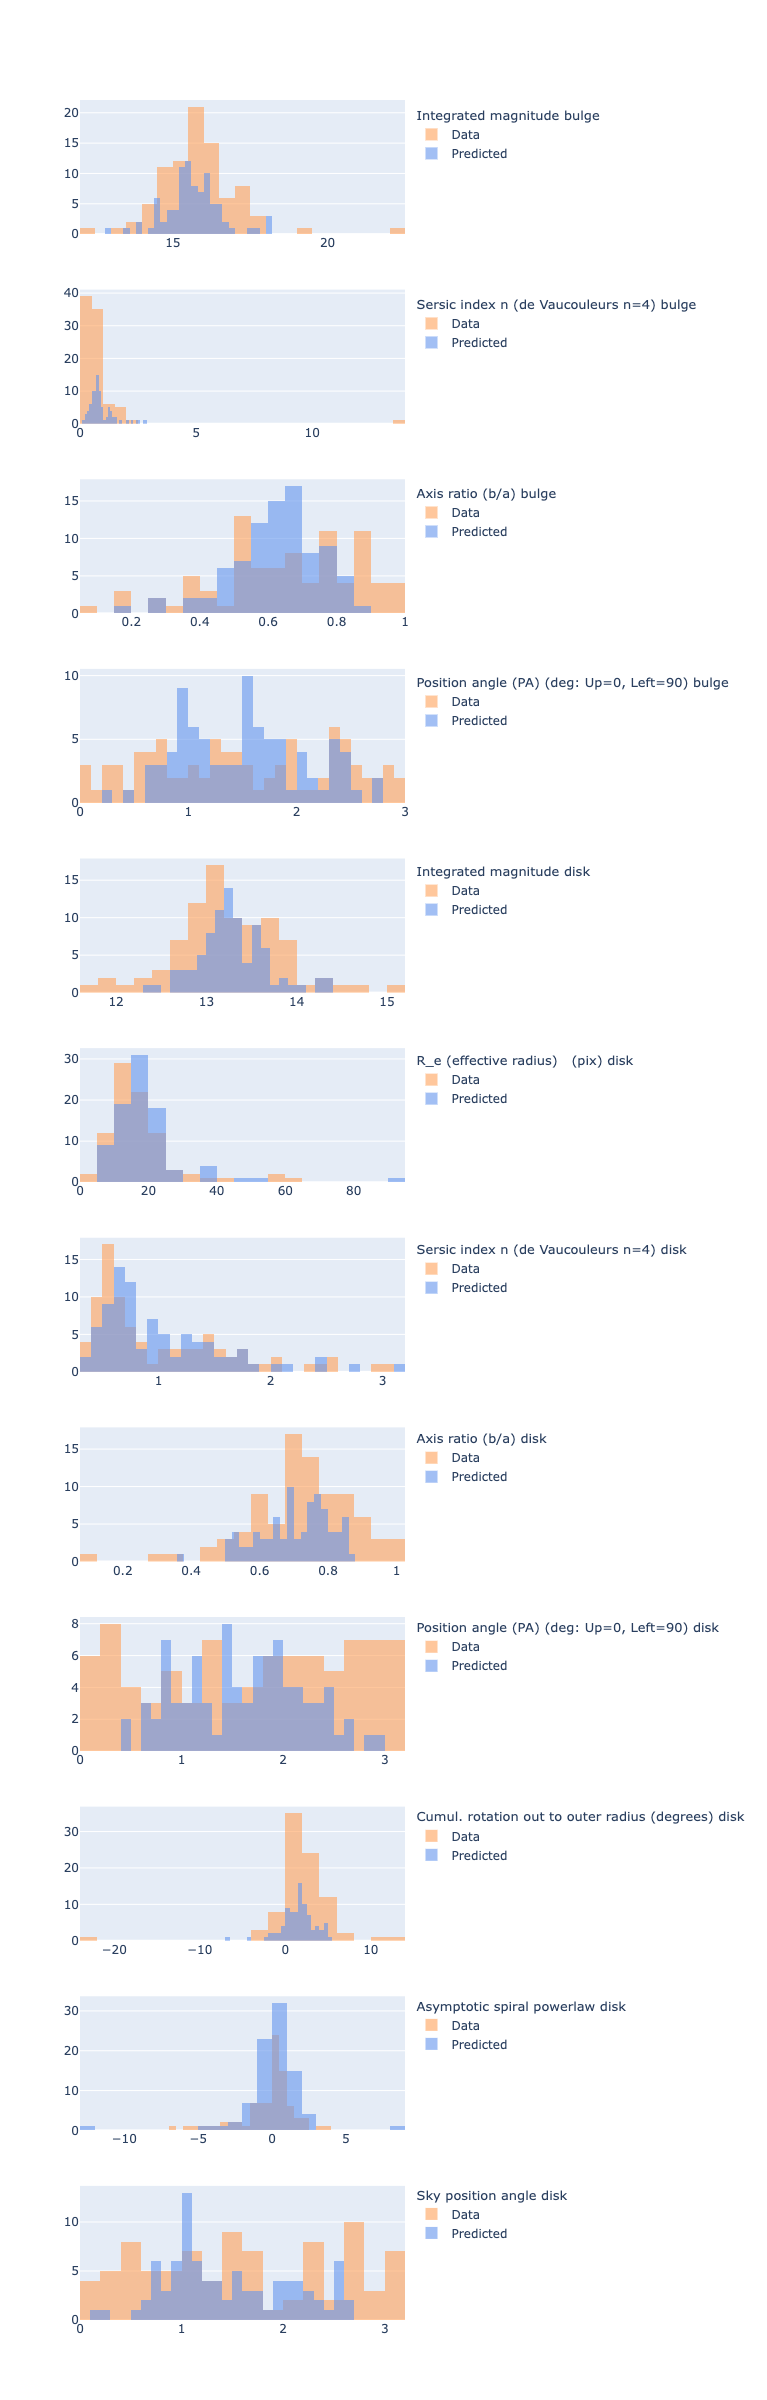

In [247]:
make_hist_plots(out_test, out_pred_df, adjust=1.83, save = False)

In [250]:
reg.save_model("xgboost_model.json")

In [483]:
reg.load_model("xgboost_model.json")

In [479]:
# Following https://machinelearningmastery.com/xgboost-for-regression/
# Lower is better
# https://machinelearningmastery.com/regression-metrics-for-machine-learning/
# define model evaluation method
# https://xgboost.readthedocs.io/en/stable/python/examples/cross_validation.html#sphx-glr-python-examples-cross-validation-py

# This should be done on *all* of the data, cross validation is a substitute for train/test split

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model, positive
scores = np.abs(cross_val_score(reg, new_in_df, new_out_df, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))

In [480]:
print("RMSE...\n")
for col, score in zip(out_train.columns, scores):
    if "degrees" in col or "position angle" in col.lower():
        score *= 180/np.pi
    print(f"{col}: {np.sqrt(score):.2f}")
#print(scores.mean(), scores.std())

RMSE...

Crop Rad: 0.32
R_e (effective radius)   (pix) bulge: 0.28
Axis ratio (b/a) bulge: 0.42
Position angle (PA) (deg: Up=0, Left=90) bulge: 1.16
R_e (effective radius)   (pix) disk: 0.08
Position angle (PA) (deg: Up=0, Left=90) disk: 1.94
Spiral outer (i.e. asymptotic) radius (pixels) disk: 0.08
Cumul. rotation out to outer radius (degrees) disk: 22.05
Asymptotic spiral powerlaw disk: 0.19
Inclination to L.o.S. (degrees) disk: 28.37


In [ ]:
fig.update_layout(
    title_text='Sampled Results', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

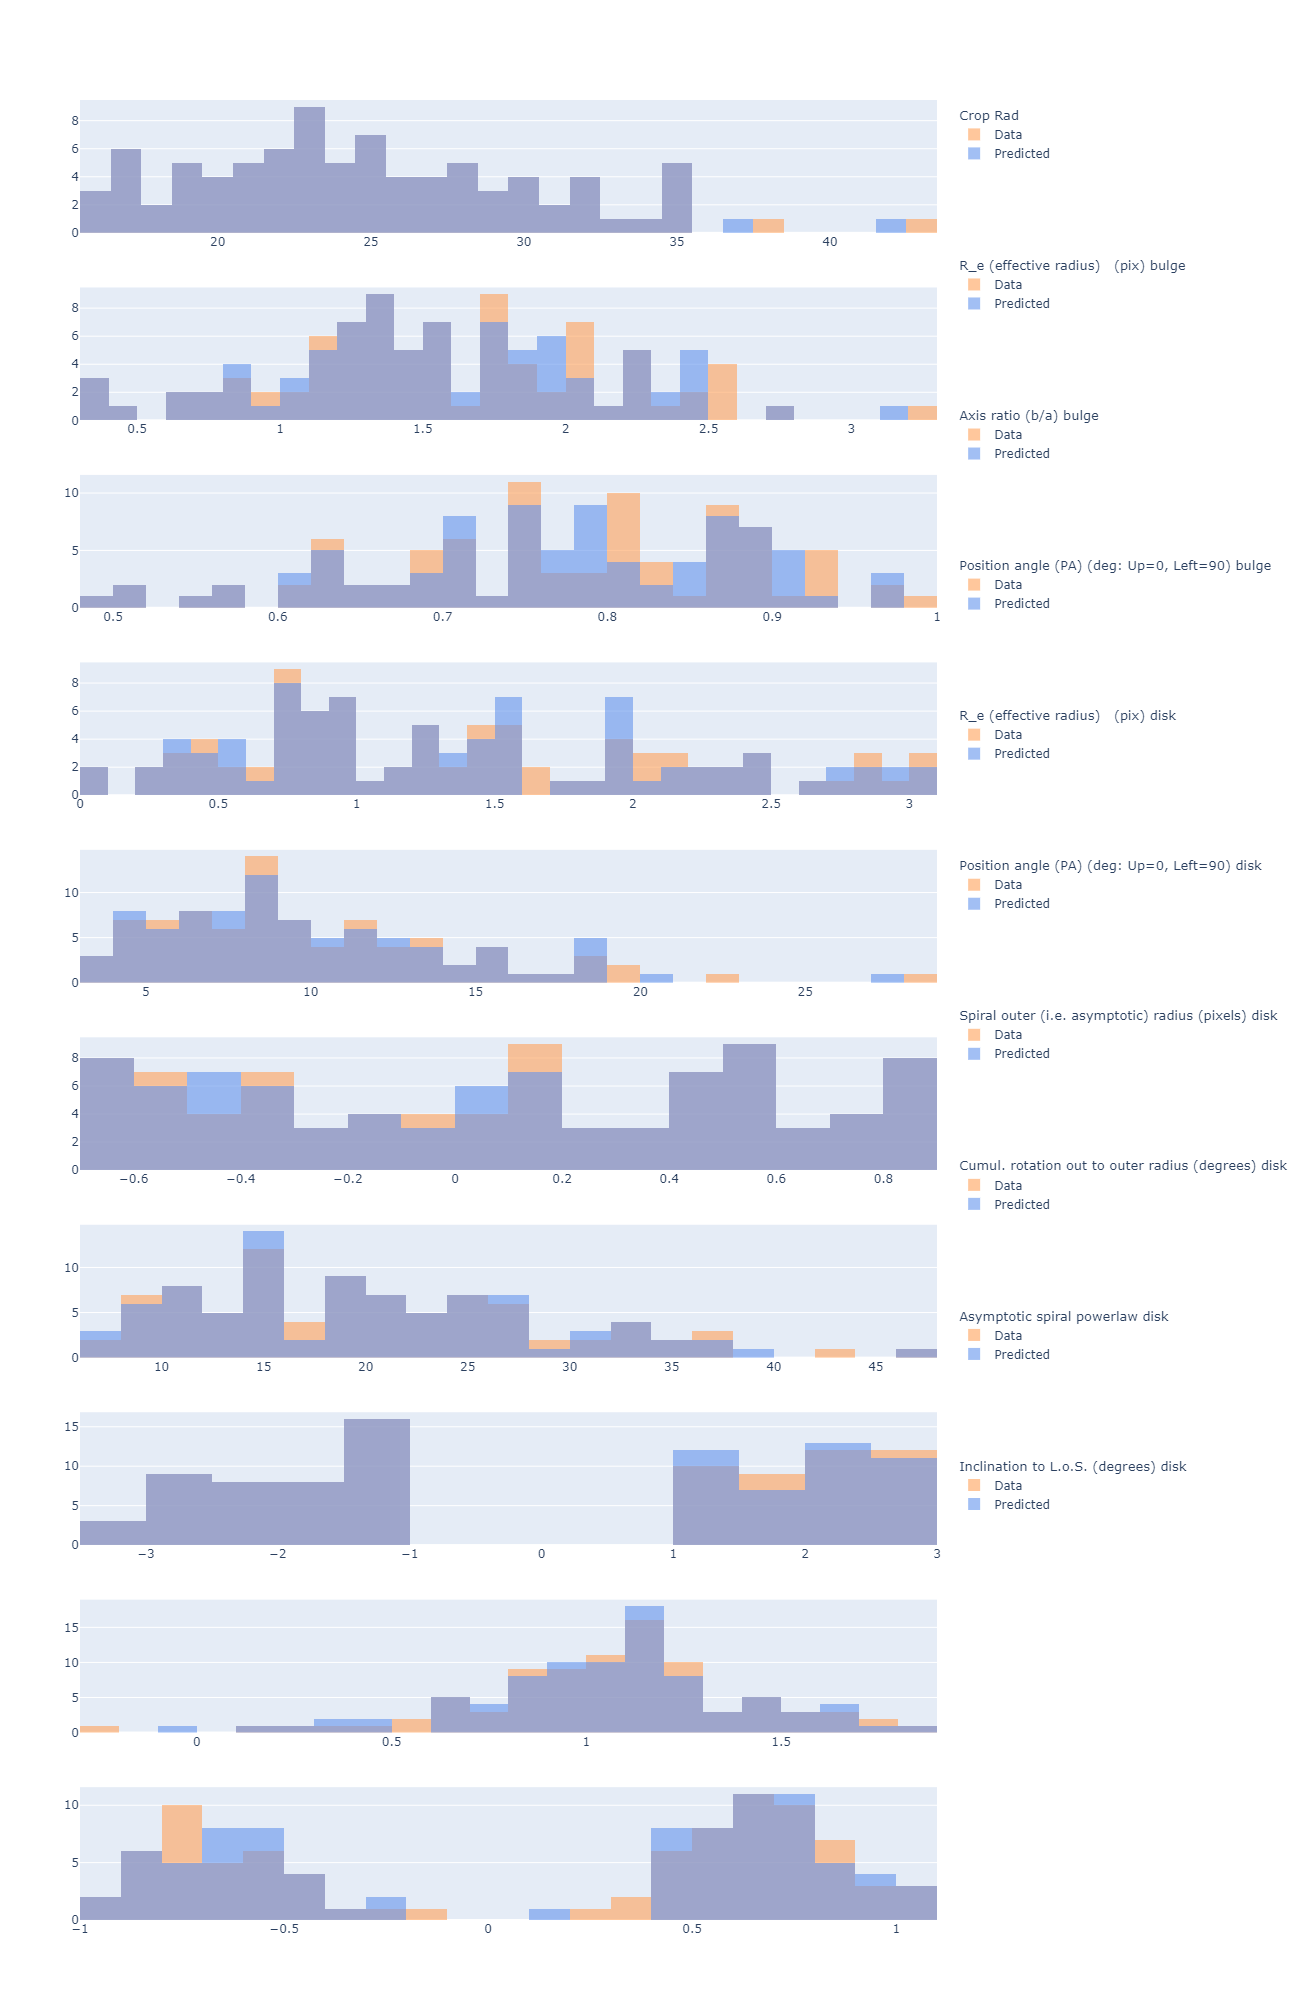

In [475]:
make_hist_plots(out_test, out_pred_df)

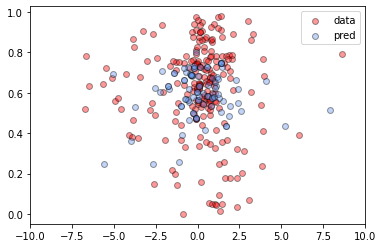

In [783]:
plot_predt(out_train.to_numpy(), reg_pred, "multi")

In [164]:
# Also I need more data
out_test_df = pd.DataFrame(reg_pred, columns = out_test.columns, index = in_test.index)
out_test_df

,Asymptotic spiral powerlaw disk,Axis ratio (b/a) bulge,Axis ratio (b/a) disk,Cumul. rotation out to outer radius (degrees) disk,Integrated magnitude bulge,Integrated magnitude disk,"Position angle (PA) (deg: Up=0, Left=90) bulge","Position angle (PA) (deg: Up=0, Left=90) disk",R_e (effective radius) (pix) bulge,R_e (effective radius) (pix) disk,Sersic index n (de Vaucouleurs n=4) bulge,Sersic index n (de Vaucouleurs n=4) disk,Sky position angle disk
1237667735053926468,-0.200305,0.586208,0.697059,2.848204,15.531620,13.467058,0.645178,0.381816,8.576777,22.666805,0.850783,1.483001,1.498435
1237668272444014757,-3.241776,0.784172,0.768653,-0.585359,17.818432,12.994648,0.146682,0.352132,13.444042,18.169834,0.614452,0.751166,1.601792
1237671123763986721,-1.321233,0.566157,0.722056,-2.263372,15.696455,13.231614,0.040521,0.427930,4.807721,17.224102,0.719034,1.072521,1.576062
1237671260133195937,1.085553,0.631660,0.615566,1.917333,15.800141,13.619308,0.422902,0.852347,11.050570,16.453081,0.771661,0.908480,2.004177
1237668271366668497,-0.569207,0.648791,0.738829,1.938184,15.696455,13.149449,-0.036239,0.517886,4.807721,22.226307,1.566155,1.372453,1.427776
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237673704507310420,-0.134031,0.672524,0.742288,-2.352603,15.663949,12.972134,0.076871,-0.806678,12.881750,22.422596,1.265281,1.101708,2.040033
1237668496330260549,1.821146,0.494219,0.713526,-3.491879,15.642205,13.160116,0.448035,0.793600,10.275883,15.105775,1.713076,1.306205,0.326051
1237667911672594651,-0.049397,0.573185,0.694273,-2.263372,15.863097,13.158751,0.106578,0.412620,7.118989,14.905628,0.597561,1.068284,1.791579
1237667915423547543,1.800265,0.488360,0.751663,-3.193300,15.704457,13.051143,0.487803,-0.390325,9.590612,15.357252,1.197436,1.375404,2.014769


In [211]:
#https://xgboost.readthedocs.io/en/stable/python/examples/multioutput_regression.html#sphx-glr-python-examples-multioutput-regression-py
def custom_rmse_model(X, y, plot_result = True) -> None:
    """Train using Python implementation of Squared Error."""

    # As the experimental support status, custom objective doesn't support matrix as
    # gradient and hessian, which will be changed in future release.
    def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
        """Compute the gradient squared error."""
        y = dtrain.get_label().reshape(predt.shape)
        return (predt - y).reshape(y.size)

    def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
        """Compute the hessian for squared error."""
        return np.ones(predt.shape).reshape(predt.size)

    def squared_log(predt: np.ndarray, dtrain: xgb.DMatrix):
        grad = gradient(predt, dtrain)
        hess = hessian(predt, dtrain)
        return grad, hess

    def rmse(predt: np.ndarray, dtrain: xgb.DMatrix):
        y = dtrain.get_label().reshape(predt.shape)
        v = np.sqrt(np.sum(np.power(y - predt, 2)))
        return "PyRMSE", v

    #X, y = gen_circle()
    Xy = xgb.DMatrix(X, y)
    results: Dict[str, Dict[str, List[float]]] = {}
    # Make sure the `num_target` is passed to XGBoost when custom objective is used.
    # When builtin objective is used, XGBoost can figure out the number of targets
    # automatically.
    # verbose_eval=False to turn off output
    booster = xgb.train(
        {
            "tree_method": "hist",
            "num_target": y.shape[1],
            "max_depth" : 4,
            "learning_rate" : 0.8,
            "gamma" : 0.002
        },
        dtrain=Xy,
        num_boost_round=75,
        obj=squared_log,
        evals=[(Xy, "Train")],
        evals_result=results,
        custom_metric=rmse,
        verbose_eval=False
    )

    y_predt = booster.inplace_predict(X)
    if plot_result:
        plot_predt(y.to_numpy(), y_predt, "multi")
        
    return booster

In [212]:
booster_model = custom_rmse_model(in_train, out_train, plot_result = False)

In [213]:
booster_outpred = booster_model.inplace_predict(in_test)
#plot_predt(in_test.to_numpy(), booster_outpred, "multi")

In [726]:
out_test_df = pd.DataFrame(booster_outpred, columns = out_test.columns, index = in_test.index)
out_test_df

,Asymptotic spiral powerlaw disk,Axis ratio (b/a) bulge,Axis ratio (b/a) disk,Cumul. rotation out to outer radius (degrees) disk,Integrated magnitude bulge,Integrated magnitude disk,"Position angle (PA) (deg: Up=0, Left=90) bulge","Position angle (PA) (deg: Up=0, Left=90) disk",R_e (effective radius) (pix) bulge,R_e (effective radius) (pix) disk,Sersic index n (de Vaucouleurs n=4) bulge,Sersic index n (de Vaucouleurs n=4) disk,Sky position angle disk
1237667735053926468,-1.362655,0.436940,0.803616,152.806854,14.929400,13.670967,42.724667,6.467973,9.701395,21.239084,1.453315,2.699100,126.985390
1237668272444014757,-0.824886,0.951839,0.792445,-61.890068,16.569298,13.559054,-27.122452,22.475266,11.687682,38.613441,0.437090,0.108417,72.687691
1237671123763986721,-3.258684,0.633761,0.752301,-113.514595,16.905720,13.116112,41.984913,63.211418,5.799139,19.057690,0.860763,1.454072,130.075150
1237671260133195937,3.252805,0.615503,0.628451,193.646912,15.737694,14.109671,32.104275,108.802422,50.413002,6.498630,0.504502,1.039243,60.825058
1237668271366668497,-0.972555,0.682005,0.769479,232.073166,16.373117,12.652014,4.609031,78.802795,4.001396,20.521500,0.685953,1.526267,107.082199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237673704507310420,-1.034595,0.649253,0.738236,-134.366425,15.977572,12.661034,11.795997,27.958706,11.475262,22.929983,0.710944,0.545805,133.143646
1237668496330260549,1.574131,0.621285,0.619254,-242.884979,16.333807,12.983774,8.469161,60.269375,11.276773,19.026085,2.212903,1.061182,80.141281
1237667911672594651,-0.445741,0.610180,0.568957,-89.392029,15.908458,12.963933,14.670424,53.180412,5.511720,20.684233,0.453192,1.477802,101.644676
1237667915423547543,1.821751,0.618869,0.681940,-221.450363,15.104543,12.936350,36.532700,-101.075989,8.704742,19.702034,0.813162,1.549093,118.129585


In [ ]:
make_hist_plots(out_test, out_test_df)
#print(len(out_test_df[np.abs(out_test_df["Asymptotic spiral powerlaw disk"]) > 2]))
#import plotly.express as px
#px.histogram(out_test_df, x ="Asymptotic spiral powerlaw disk")

In [ ]:
# Idea:
# Figure out which parameters my algorithm is worst at then regress on those
# rather than on the whole thing at once... that doesn't seem to be working well lolol

In [129]:
# Visualize data
#dtrain.get_data().toarray()

In [506]:
# Classification
# Optimizing hyperparameters using hyperopt???
# Bayesian Optimization
space = {'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
         'max_depth': hp.quniform('max_depth', 3, 18, 1),
         'subsample' : hp.uniform('subsample', 0.5, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 0, 5, 1),
         'max_delta_step' : hp.quniform('max_delta_step', 0, 10, 1),
         'min_split_loss': hp.uniform ('min_split_loss', 1,9),
         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
         'n_estimators': 180,
         'seed': 0
        }

In [176]:
# Objective function
def objective(space): #, data, label, test_size = 0.3):
    clf = XGBRegressor(
                    learning_rate = space['learning_rate'],
                    n_estimators = space['n_estimators'],
                    subsample = space['subsample'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['min_split_loss'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    clf.set_params(eval_metric="auc", 
                   early_stopping_rounds=10,
                   objective='reg:squarederror'
                   #'eval_metric' : 'error' # Binary classification error rate
                   )
    
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = test_size)
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print (f"SCORE: {accuracy:.3f}")
    return {'loss': -accuracy, 'status': STATUS_OK }

In [183]:
trials = Trials()

data = ddata.get_data()
label = ddata.get_label()
test_size = 0.3

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE: 0.645                                           
SCORE: 0.716                                           
SCORE: 0.726                                                                      
SCORE: 0.706                                                                      
SCORE: 0.669                                                                     
SCORE: 0.742                                                                     
SCORE: 0.716                                                                      
SCORE: 0.702                                                                      
SCORE: 0.656                                                                      
SCORE: 0.699                                                                      
SCORE: 0.659                                                                      
SCORE: 0.689                                                                       
SCORE: 0.672                                               

In [184]:
best_hyperparams_int = {k:(int(v) if int(float(v)) == v else v) for k,v in best_hyperparams.items()}       
print("The best hyperparameters are : ","\n")
print(best_hyperparams_int)

The best hyperparameters are :  

{'colsample_bytree': 0.7235935672223129, 'learning_rate': 0.08729916004044301, 'max_delta_step': 4, 'max_depth': 10, 'min_child_weight': 2, 'min_split_loss': 5.623670980429336, 'reg_alpha': 130, 'reg_lambda': 0.7885654202661125, 'subsample': 0.753167836602898}


In [181]:
# Setting parameters
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
param = {'max_depth': 10, # Be wary of overfitting
         'learning_rate': 0.1,
         'min_split_loss' : 1, # How conservative the algorithm will be 
         'min_child_weight' : 2, # Control over-fitting, higher = more conservative
         'max_delta_step' : 2, # Control update step, higher = more conservative
         'subsample' : 0.5, # Fraction of observations randomly sampled for each tree, lower = more conservative
         'objective': 'binary:logistic', # logistic regression for binary classification
                                         # Regression
         'eval_metric' : 'error', # Binary classification error rate
         'verbosity' : 1
        }
#param['nthread'] = 4

In [186]:
# Ideas to supplement training:
# Slightly modify parameters and see if galfit produces the same galaxies (do this by diff checking)
# if so we retain output labels even if input is different
evallist = [(dtrain, 'train'), (dtest, 'eval')]
# Training
num_round = 50
#bst = xgb.train(best_hyperparams_int, dtrain, num_round, evals = evallist)
bst = xgb.train(param, dtrain, num_round, evals = evallist)

[0]	train-error:0.30029	eval-error:0.40134
[1]	train-error:0.27586	eval-error:0.34114
[2]	train-error:0.26006	eval-error:0.33110
[3]	train-error:0.23563	eval-error:0.30769
[4]	train-error:0.23707	eval-error:0.30769
[5]	train-error:0.21983	eval-error:0.29097
[6]	train-error:0.22414	eval-error:0.30100
[7]	train-error:0.22414	eval-error:0.28428
[8]	train-error:0.21121	eval-error:0.28763
[9]	train-error:0.20546	eval-error:0.30100
[10]	train-error:0.19684	eval-error:0.29431
[11]	train-error:0.20546	eval-error:0.28094
[12]	train-error:0.20402	eval-error:0.28094
[13]	train-error:0.20690	eval-error:0.27759
[14]	train-error:0.18534	eval-error:0.27759
[15]	train-error:0.18103	eval-error:0.27759
[16]	train-error:0.17960	eval-error:0.27090
[17]	train-error:0.17529	eval-error:0.26756
[18]	train-error:0.17385	eval-error:0.27425
[19]	train-error:0.16092	eval-error:0.26421
[20]	train-error:0.16092	eval-error:0.26756
[21]	train-error:0.15948	eval-error:0.26421
[22]	train-error:0.14799	eval-error:0.2474

In [138]:
preds = bst.predict(dtest)
labels = dtest.get_label()
print(
    "error=%f"
    % (
        sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i])
        / float(len(preds))
    )
)

error=0.341137


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

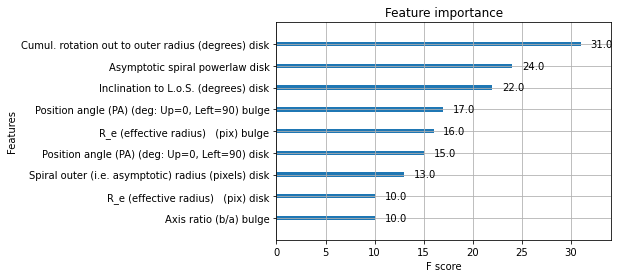

In [91]:
xgb.plot_importance(bst)

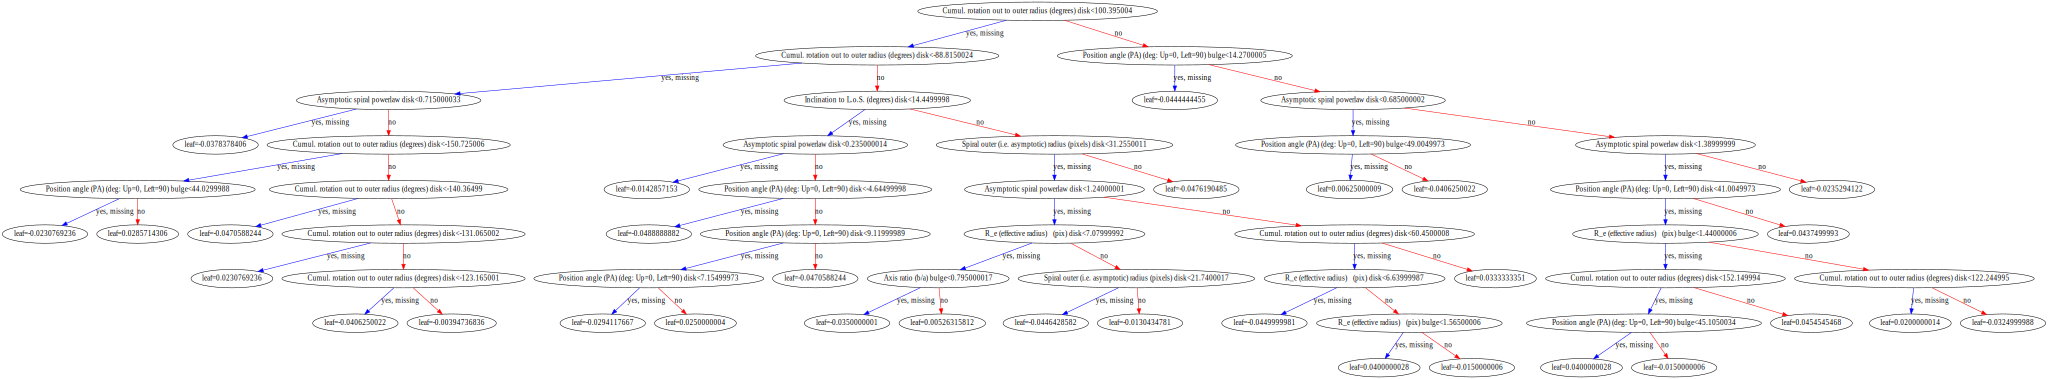

In [23]:
xgb.to_graphviz(bst, num_trees=0)

#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 1,1
#xgb.plot_tree(bst, num_trees=0, rankdir='LR')
#plt.show()

In [ ]:
# Save model
bst.save_model('test.model')

In [ ]:
# Load model
bst = xgb.Booster() #{'nthread': 4})  # init model
bst.load_model('test.model')  # load data

In [ ]:
#https://xgboost.readthedocs.io/en/stable/get_started.html
#https://xgboost.readthedocs.io/en/stable/tutorials/index.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#https://xgboost.readthedocs.io/en/stable/python/python_intro.html#prediction
X_train, X_test, y_train, y_test = train_test_split(galfit_in_df.loc[:, galfit_in_df.columns != "label"], galfit_in_df['label'], test_size=.3)

In [ ]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

In [ ]:
bst.fit(X_train, y_train)

In [ ]:
preds = bst.predict(X_test)

In [ ]:
# Ideas: obviously look at just input first and then just output
# Can also look at the *difference* between these two